In [23]:
import os # 환경변수 값을 운영체제에 저장하겠다는 뜻
import requests
# 중요하다고 생각되어지는 변수는 환경변수(식별을 위해 대문자로 씀. 소문자로 해도 상관은 없다)에 담는다
# url = "?language=ko-KR&page=1&api_key=5a0c1a157339dedc441ce571ae6193ed"
import pandas as pd


API_KEY = os.getenv("TMDB_API_KEY", "5a0c1a157339dedc441ce571ae6193ed")
NOW_LANG = "ko-KR"
PAGE = 1
GENRE_LANG = "ko"
POSTER_BASE = "https://image.tmdb.org/t/p/w500"
BACKDROP_BASE = "https://image.tmdb.org/t/p/w780"
# 상대경로 | 절대경로
# 'backdrop_path': '/3F2EXWF1thX0BdrVaKvnm6mAhqh.jpg' 이런식으로 앞에 URL이 없는것 -> 상대경로. 앞에 경로값을 써줘야함

# genres 데이터 적용하기
def genre_ids_to_names(ids, genre_map: dict) -> str :
    #[28, 53, 80] -> '액션|스릴러|범죄' 이렇게 바꾸고 싶은 것

    if not isinstance(ids, list) :
        return ""

    names = [genre_map.get(i, str(i)) for i in ids]  # ["액션", "스릴러", "범죄"] -> 이런식으로 들어가 있음
    return "|".join(names)    # '액션|스릴러|범죄'-> 이렇게 바꿔


# 텍스트 개행 수정 함수
def clean_one_line(text: str) -> str :
    if not text : 
        return ""
    text = text.replace("\n", " ")
    
    return " ".join(text.split())
    
# genres 데이터 가져오기
def fatch_genre_map(api_key: str, language: str = "ko") -> dict :
    url = "https://api.themoviedb.org/3/genre/movie/list"
    parmas = {"api_key": api_key, "language":  NOW_LANG, "page": PAGE}
    res = requests.get(url, params=parmas, timeout=20)
    res.raise_for_status()

# 구문이 길어지면 헷갈리니까 안전하게 타입 표기법을 쓰기도 한다 <api_key: str> 이런식으로

    genres = res.json(). get("genres", [])
    return {g["id"] : g["name"] for g in genres}    # {28 : "액션", 12: "모험"...}

# genres 값 찾아오기
genre_map = fatch_genre_map(API_KEY, GENRE_LANG)

# now_playing 데이터 가져오기
url = "https://api.themoviedb.org/3/movie/now_playing"
params = {"api_key": API_KEY, "language": NOW_LANG, "page": PAGE}



res = requests.get(url, params=params, timeout=20)
res.raise_for_status()

data = res.json()

rows = []

for m in data.get("results", []) :
    poster_path = m.get("poster_path")
    backdrop_path = m.get("backdrop_path")

    poster_url = f"{POSTER_BASE}{poster_path}" if poster_path else ""
    backdrop_url = f"{BACKDROP_BASE}{backdrop_path}" if backdrop_path else ""
    genre_ids = m.get("genre_ids", [])
    
    rows.append({
        "id": m.get("id"), 
        "title": m.get("title"), 
        "original_title": m.get("original_title"), 
        "overview": clean_one_line(m.get("overview")), 
        "genre_ids": ",".join(map(str, genre_ids)) if isinstance(genre_ids, list) else "", 
        "genre_names": genre_ids_to_names(genre_ids, genre_map),
        "adult": m.get("adult"),
        "original_language": m.get("original_language"),
        "vote_average": m.get("vote_average"),
        "popularity": m.get("popularity"),
        "vote_count": m.get("vote_count"),
        "poster_url": poster_url,
        "backdrop_url": backdrop_url
    })

    
df = pd.DataFrame(rows, columns=[
    "id", 
    "title", 
    "original_title",
    "overview", 
    "genre_ids",
    "genre_names",
    "adult",
    "original_language",
    "vote_average",
    "popularity",
    "vote_count",
    "poster_url",
    "backdrop_url"
])


out_path = "tmdb_now_paying.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"✅저장완료 : {out_path} (rows={len(df)})")
df.head()


# """
# id | title | original_title | adult -> field명 그룹 => 이걸 colums 라고 함
# 1     더립       the rip      false
# """


✅저장완료 : tmdb_now_paying.csv (rows=20)


,id,title,original_title,overview,genre_ids,genre_names,adult,original_language,vote_average,popularity,vote_count,poster_url,backdrop_url
0,1306368,더 립,The Rip,허름한 은닉처에서 수백만 달러의 현금을 발견한 마이애미 경찰. 신뢰에 금이 가기 시...,"28,53,80",액션|스릴러|범죄,False,en,7.033,346.4826,842,https://image.tmdb.org/t/p/w500/o0d6Us9VWOW0nH...,https://image.tmdb.org/t/p/w780/3F2EXWF1thX0Bd...
1,1043197,더스트 바니,Dust Bunny,“어른도 아이도 함께하는 몬스터 사냥 이야기” 열 살 소녀 오로라는 침대 밑에 숨어...,"28,14,53",액션|판타지|스릴러,False,en,6.564,288.1896,128,https://image.tmdb.org/t/p/w500/vobigFZFvbYPf6...,https://image.tmdb.org/t/p/w780/AecGG1XVCmkk7f...
2,83533,아바타: 불과 재,Avatar: Fire and Ash,"인간들과의 전쟁으로 첫째 아들 ‘네테이얌’을 잃은 후, ‘제이크’와 ‘네이티리’는 ...","878,12,14",SF|모험|판타지,False,en,7.308,241.8643,1631,https://image.tmdb.org/t/p/w500/l18o0AK18KS118...,https://image.tmdb.org/t/p/w780/3Dqievkc7krcTt...
3,991494,스폰지밥 무비: 네모바지를 찾아서,The SpongeBob Movie: Search for SquarePants,비키니시티에 사는 스폰지밥은 무시무시한 롤러코스터를 탈 수 있는 용감한 ‘빅 가이’...,"16,10751,35,12,14",애니메이션|가족|코미디|모험|판타지,False,en,6.526,183.5545,136,https://image.tmdb.org/t/p/w500/2QCGC4toQXYuIs...,https://image.tmdb.org/t/p/w780/gbjK8p5S1aLXWC...
4,1368166,하우스메이드,The Housemaid,과거를 숨긴 채 완벽한 저택의 가정부로 들어간 밀리가 이상한 행동을 보이는 아내 니...,"9648,53",미스터리|스릴러,False,en,7.102,157.4883,542,https://image.tmdb.org/t/p/w500/fUDX16A4fJXmAu...,https://image.tmdb.org/t/p/w780/sK3z0Naed3H1Wu...


In [27]:
import pandas as pd

CSV_PATH = "tmdb_now_paying.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

num_cols = ["vote_average", "popularity", "vote_count"]

for c in num_cols :
    if c in df.columns :
        df[c] = pd.to_numeric(df[c], errors="coerce")

def split_genres(x: str) :
    x = "" if pd.isna(x) else str(x).strip() # isna() = is -> true냐 false냐 / na = not available = 사용할 수 없는 값 = 결측치 / 인자값으로 들어온 값이 사용할 수 없는 값인지 묻는 것
    if not x :
        return []
    if "|" in x :
        parts = [p.strip() for p in x.split("|")]
    else :
        parts = [p.strip() for p in x.split(",")]  
    return [p for p in parts if p]

df_g = df.copy()
df_g["genre"] = df_g["genre_names"].apply(split_genres)
df_g = df_g.explode("genre")

# aggregation : 집계
agg = (
    df_g.groupby("genre", as_index=False)
    .agg(
        movie_count=("id", "nunique"),
        avg_popularity=("popularity", "mean"),  # mean : 평균을 의미
        avg_vote_average=("vote_average", "mean"),
        avg_vote_count=("vote_count", "mean"),
    )
)

agg
        
# 시각화를 한다는 것은 -> 차트 |도표를 만든다는 것
# 데이터를 수치화(숫자) 시켜줘야한다
# 남/여 -> 남=0, 여=1
# 10대,20대, 30대, -> 10대=0, 20대=1, 30대=2

,genre,movie_count,avg_popularity,avg_vote_average,avg_vote_count
0,SF,6,111.126967,6.990833,351.166667
1,가족,1,183.554500,6.526000,136.000000
2,공포,5,88.190960,6.492200,883.600000
3,드라마,4,133.712250,6.360250,185.000000
4,모험,4,148.664050,6.683500,480.750000
5,미스터리,3,117.834467,6.036000,212.000000
6,범죄,4,192.833475,7.037250,964.250000
7,스릴러,14,137.773407,6.616571,652.500000
8,애니메이션,2,120.629900,7.513000,75.000000
9,액션,9,160.758267,6.790000,838.222222


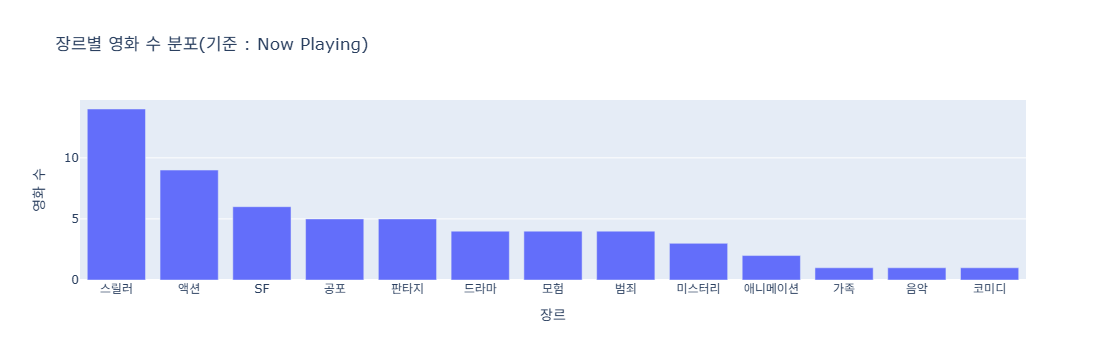

In [32]:
import plotly.express as px

fig = px.bar(
    agg.sort_values("movie_count", ascending=False),  # 정렬하라고 하면 오름차순이 기본
    x="genre",
    y="movie_count",
    title="장르별 영화 수 분포(기준 : Now Playing)"
)

fig.update_layout(xaxis_title="장르", yaxis_title="영화 수")   # x(가로)축, y(세로)축 이름 변경
fig.show()

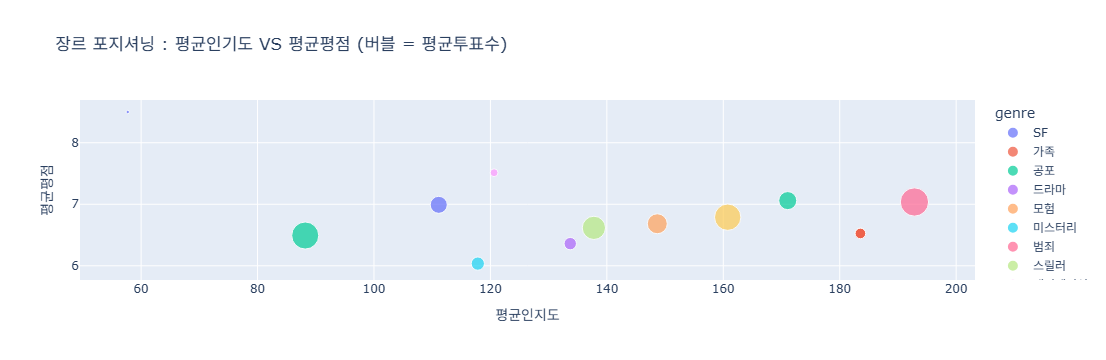

In [38]:
import plotly.express as px

# 산점도 그래프 : 점을 흩어뿌리는 형태의 그래프
fig = px.scatter(
    agg,
    x="avg_popularity",
    y="avg_vote_average",
    hover_name="genre", # 어떤 장르인지 이름 표기
    color="genre", # 장르에 따라 컬러 변경
    size="avg_vote_count", # 투표한 사람들의 규모를 점 사이즈로 다르게 보여주기
    title="장르 포지셔닝 : 평균인기도 VS 평균평점 (버블 = 평균투표수)"
)

fig.update_layout(xaxis_title="평균인지도", yaxis_title="평균평점")
fig.show()

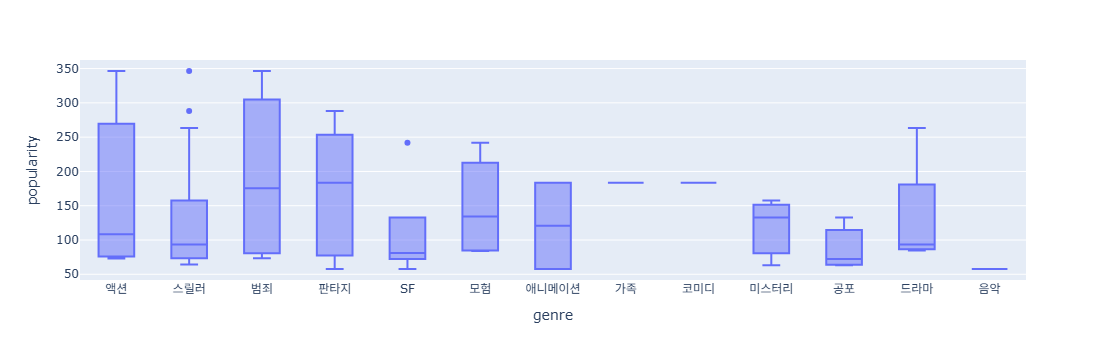

In [39]:
import plotly.express as px

fig = px.box(
    df_g,
    x="genre",
    y="popularity"
)

fig.show()

In [ ]:
- [12, 15, 18, 20, 22, 25, 30, 35, 40, 100] -> 전체 데이터
- 100을 제외 하고 나머지 값은 50 근처에 머물러 있다. 이 값을 단순 평균을 내면 안된다
- 일반적으로 데이터를 분석할 때는 평균을 사용하기도 하지만, 중앙(중간)값을 사용하기도 한다 = median =  물리적인 가운데 값을 의미
- 짝수 / 홀수냐에 따라 달라진다. 
- 만약 짝수인 경우 5번째 + 6번째 값을 더한 평균
- 만약 홀수인 경우 그 가운데 1개값
- median = (22 + 25) / 2 = 23.5
- median 값이 중간에 위치할 수록 전체적인 데이터가 중간에 있다는 뜻
- 하위 50% = 12, 15, 18 20, 22
- 하위 50%의 중앙값 = 1사분위 = Q1 = 하위 데이터의 25% = 18 (하위 25%)
- 상위 50% = 25, 30, 35, 40, 100
- 상위 50%의 중앙값 = 3사분위 = Q3 = 상위 데이터의 25% = 35 (상위 25%)
- IQR = Inter Quartile Range = 중앙값 기준 퍼짐정도
- Q3 - Q1 = 35 - 18 = 17 (중앙을 기준으로 반지름 17 정도의 값이 있다)

-Lower Fence = 하한치 = Q1 - IQR * 1.5 = 18 - (17 * 1.5) = 18 - 25.5 = -7.5
-Upper Fence = 상한치 = Q3 + IQR * 1.5 = 35 + (17 * 1.5) = 35 + 25.5 = 60.5
-학군 분석할때 많이 쓴다

-min = 12
-max = 40
-이상치 = 60.5를 넘어간 값 = Outlier = 100

-mean = 평균값 = (12 + 15 + 18 + 20 + 22 + 25 + 30 + 35 + 40 + 100) / 10 = 31.7
-편차 = 평균에서의 차이 12 - 31.7 = -19.7
-평균으로부터 대체적으로 얼만큼 떨어져 있는지가 알고 싶어서 편차를 구하는 것
-표준편차 = 모든 편차의 평균
-제곱편차 = 모든 편차의 값을 제곱한다 = 388.09 / 278.89 / 187.69 ~~~ 4664.89 => 5878.10
-제곱편차 / 10 = 모분산 = 모집단의 분산 = 587.81 => 10개의 데이터가 확실하게 고정
-제곱편차 / n(전체집단) - 1 = 표분산 = 표본 집단의 분산 = 653.12 => 계산해야할 값이 너무 많을때 표본이 되는 값을 뽑는다 -> 과소추정법칙
-모집단을 기준으로 표준 편차 값 : r 587.81 = 24.24
-표집단을 기준으로 표준 편차 값 : r 653.12 = 25.25

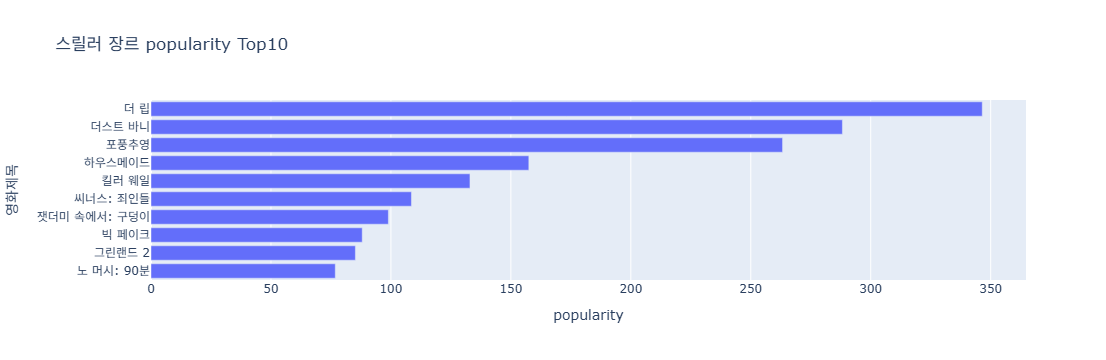

In [46]:
import plotly.express as px

TARGET_GENRE = "스릴러"
TOP_N = 10

tmp = df_g[df_g["genre"] == TARGET_GENRE].copy()
tmp = tmp.dropna(subset=["popularity"])
tmp = tmp.sort_values("popularity", ascending=False).head(TOP_N)

fig = px.bar(
    tmp.sort_values("popularity"),
    x = "popularity",
    y = "title",
    hover_data=["vote_average", "vote_count", "original_language"],
    title=f"{TARGET_GENRE} 장르 popularity Top{TOP_N}"
)
fig.update_layout(xaxis_title="popularity", yaxis_title="영화제목")
fig.show()